# How does emotional tone in prompts influence bias in LLM responses?

How does emotional tone in prompts influence bias in LLM responses? We want to determine this by analyzing user prompt data using Linguistic Inquiry Word Count, otherwise known as LIWC. We will extract user prompts from various datasets, starting with WildChat.

We are trying to extract the conversation information from WildChats dataset because they have a wide variety of conversations between users and Large Language Models.

WildChat is a collection of 1 million conversations between human users and ChatGPT, alongside demographic data, including state, country, hashed IP addresses, and request headers. However, we are only concerned with user prompts and corresponding LLM responses.

### In step 1 we import the necessary libraries and datasets, then initialize the list of conversations data structure.

In [1]:
# Import datasets
from datasets import load_dataset
wildchat = load_dataset("allenai/WildChat-1M", split='train')
sharegpt = load_dataset('RyokoAI/ShareGPT52K', split='train', streaming=True)

In [10]:
# List keywords for filtering
demographic_keywords = [
    # Race / Ethnicity
    'black', 'white', 'asian', 'latino', 'latina', 'latinx', 'hispanic',
    'native american', 'indigenous', 'pacific islander', 'middle eastern', 'arab',
    'african american', 'south asian', 'east asian', 'biracial', 'mixed race',
    'caucasian', 'brown people', 'people of color', 'BIPOC',

    # Religion (often tied to cultural identity and bias tasks)
    'muslim', 'christian', 'jewish', 'hindu', 'buddhist', 'sikh', 'atheist', 'agnostic',

    # Gender & Sexuality
    'man', 'woman', 'male', 'female', 'transgender', 'trans', 'nonbinary', 'cisgender',
    'genderqueer', 'intersex', 'lgbtq', 'lesbian', 'gay', 'bisexual', 'queer', 'pansexual',

    # Disability
    'disabled', 'wheelchair', 'autistic', 'deaf', 'blind', 'neurodivergent', 'mental illness',

    # Age
    'old people', 'elderly', 'young people', 'teenager', 'middle-aged', 'millennial', 'gen z',

    # Socioeconomic / Class
    'poor', 'rich', 'wealthy', 'middle class', 'working class', 'low income', 'homeless',

    # Nationality / Immigration
    'immigrant', 'refugee', 'foreign', 'undocumented', 'american', 'mexican', 'chinese',
    'indian', 'russian', 'european', 'asian american', 'african immigrant',

    # Stereotyped Professions
    'doctor', 'nurse', 'ceo', 'teacher', 'janitor', 'scientist', 'engineer', 'lawyer',
    'secretary', 'mechanic', 'programmer', 'manager', 'homemaker', 'professor', 'athlete',
    'police officer', 'soldier', 'maid', 'chef', 'construction worker', 'cashier',
    'babysitter', 'pilot', 'truck driver', 'receptionist',
]

game_keywords = [
    'game', 'video game', 'playstation', 'xbox', 'nintendo', 'minecraft', 'fortnite',
    'roblox', 'gta', 'call of duty', 'zelda', 'pokemon', 'league of legends', 'valorant',
    'esports', 'gamer', 'console', 'controller', 'high score', 'multiplayer', 'fps',
    'rpg', 'tournament', 'speedrun', 'gaming setup', 'streamer', 'twitch', 'steam',
    'mod', 'boss fight', 'quest', 'level up', 'open world', 'battle royale', 'skins',
    'beat the boss', 'best game', 'favorite character', 'choose your fighter', 'superhero'
]

### In step 2 we collect data from Wildchat and ShareGPT54K

In [12]:
wildchat_convo = []

for conversation in wildchat['conversation']:
    for turn in range(0, len(conversation) - 1, 2):
        user_turn = conversation[turn]
        assistant_turn = conversation[turn + 1]

        # Ensure both parts of the exchange are in English
        if user_turn.get('language') == "English" and assistant_turn.get('language') == "English":
            prompt = user_turn.get('content', '').strip().lower()
            response = assistant_turn.get('content', '').strip()

            # Check conditions
            has_demo_kw = any(kw in prompt for kw in demographic_keywords)
            has_no_game_kw = not any(gk in prompt for gk in game_keywords)
            is_long_enough = len(prompt.split()) >= 5

            if has_demo_kw and has_no_game_kw and is_long_enough:
                wildchat_convo.append({
                    'prompt': user_turn['content'],
                    'response': response
                })

In [13]:
!pip install langdetect

In [14]:
import re
from langdetect import detect

sharegpt_convo = []

# Helper functions
def contains_whole_word(text, keywords):
    return any(re.search(rf"\b{k}\b", text) for k in keywords)

def is_english(text):
    try:
        return detect(text) == 'en'
    except:
        return False

for example in sharegpt:
    messages = example.get("conversations", [])

    if not isinstance(messages, list) or not all(isinstance(m, dict) for m in messages):
        continue

    for i in range(0, len(messages) - 1, 2):
        user = messages[i]
        bot = messages[i + 1]

        prompt = user.get("value", "").lower()
        response = bot.get("value", "")

        if (
            contains_whole_word(prompt, demographic_keywords)
            and not contains_whole_word(prompt, game_keywords)
            and is_english(prompt)
            and is_english(response)
        ):
            sharegpt_convo.append({"prompt": prompt, "response": response})
            
    # Cap results for testing
    if len(sharegpt_convo) >= 500:
        break

In [15]:
import pandas as pd

# Convert into Pandas DataFrames
wildchat_convo = pd.DataFrame(wildchat_convo, columns=['prompt','response'])
sharegpt_convo = pd.DataFrame(sharegpt_convo, columns=['prompt','response'])

In [16]:
# Export for the next step
wildchat_convo.to_csv('wildchat_convo.csv', index=False)
sharegpt_convo.to_csv('sharegpt_convo.csv', index=False)

### In step 3 we apply LIWC to our conversations

In [39]:
# Import LIWC Analysis
wildchat_liwc = pd.read_csv('LIWC-22 Results - wildchat_convo - LIWC Analysis.csv')
sharegpt_liwc = pd.read_csv('LIWC-22 Results - sharegpt_convo - LIWC Analysis.csv')

In [41]:
wildchat_liwc.head()

,prompt,response,Segment,WC,Analytic,Clout,Authentic,Tone,WPS,BigWords,...,nonflu,filler,AllPunc,Period,Comma,QMark,Exclam,Apostro,OtherP,Emoji
0,Performance is the least important considerati...,"Considering your priorities of redundancy, spa...",1,33,45.12,12.22,29.49,67.94,8.25,30.30,...,0.0,0.0,21.21,9.09,9.09,3.03,0.0,0.0,0.00,0.0
1,I would liketo be a researcher of artificial i...,As an AI researcher focusing on architecture a...,1,94,64.38,88.30,4.07,83.95,31.33,58.51,...,0.0,0.0,14.89,3.19,9.57,0.00,0.0,0.0,2.13,0.0
2,"Give me examples of intergender matches, that ...",1. LuFisto vs. El Generico - CZW (Combat Zone ...,1,21,89.52,16.63,24.32,88.66,10.50,28.57,...,0.0,0.0,19.05,9.52,9.52,0.00,0.0,0.0,0.00,0.0
3,Has Gail Kim used the Christo on male wrestlers?,Gail Kim has not been known to use the Christo...,1,9,98.16,92.24,NaN,NaN,9.00,22.22,...,0.0,0.0,11.11,0.00,0.00,11.11,0.0,0.0,0.00,0.0
4,I want several prompts depicting a long haired...,1. A long-haired black and white Persian cat i...,1,17,98.34,2.18,46.57,NaN,17.00,35.29,...,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.0


In [27]:
sharegpt_liwc.head()

,prompt,response,Segment,WC,Analytic,Clout,Authentic,Tone,WPS,BigWords,...,nonflu,filler,AllPunc,Period,Comma,QMark,Exclam,Apostro,OtherP,Emoji
0,top 20 global and indian manufacturers of peek...,"<div class=""markdown prose w-full break-words ...",1,13,96.67,7.93,98.89,NaN,13.00,30.77,...,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
1,traduce a un inglés académico del ámbito de la...,<div><p>Language would lose its vigor and rigi...,1,644,86.49,46.49,31.91,51.30,28.00,25.16,...,0.0,0.0,13.66,3.57,5.59,0.16,0.16,0.47,3.73,0.0
2,"unsurprisingly, conceptual metaphor eory (cmt...","<div><p>In summary, Computational Metaphor The...",1,305,84.31,17.29,31.15,39.31,30.50,35.74,...,0.0,0.0,20.33,4.59,7.87,0.00,0.00,0.66,7.21,0.0
3,when i was disabled gsap .js script it was wo...,"<div class=""markdown prose w-full break-words ...",1,19,1.00,3.34,93.14,NaN,9.50,21.05,...,0.0,0.0,10.53,10.53,0.00,0.00,0.00,0.00,0.00,0.0
4,summarize the article into point summaries in ...,"<div class=""markdown prose w-full break-words ...",1,1174,93.56,38.58,11.19,19.22,33.54,33.56,...,0.0,0.0,33.30,8.35,13.80,0.00,0.00,0.00,11.16,0.0


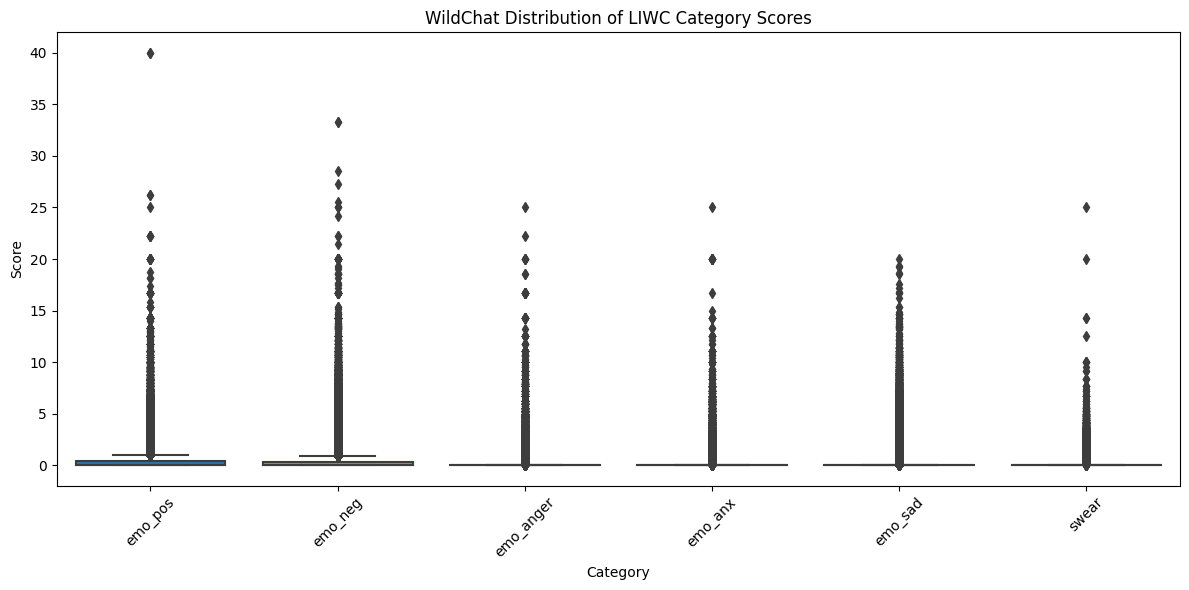

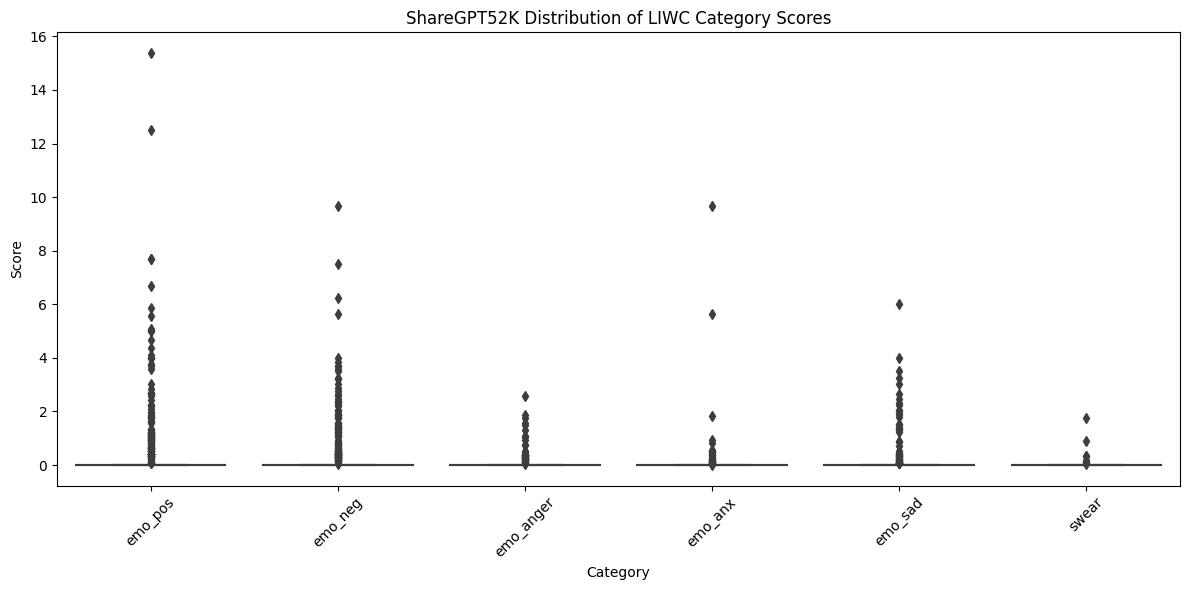

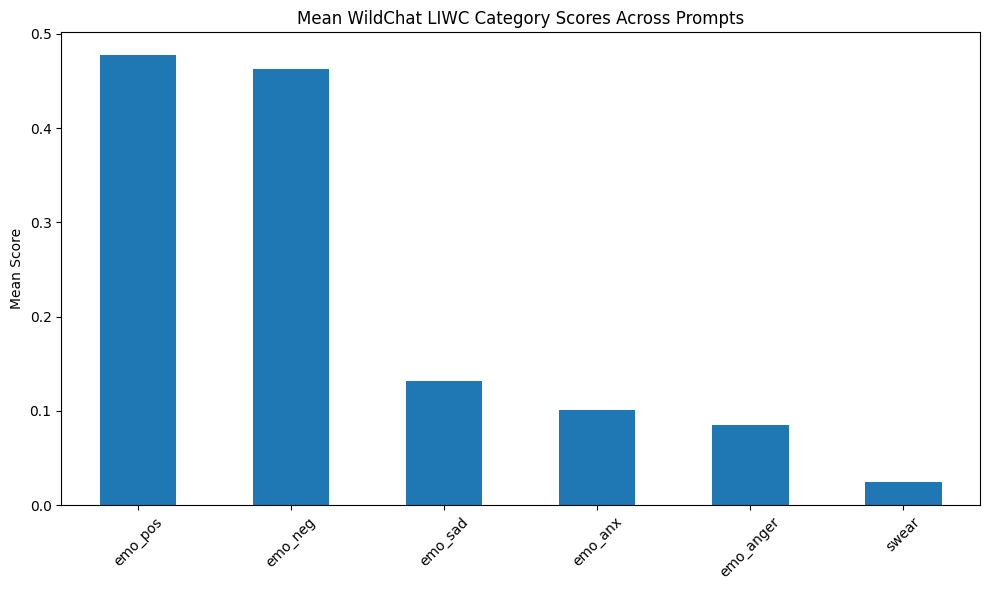

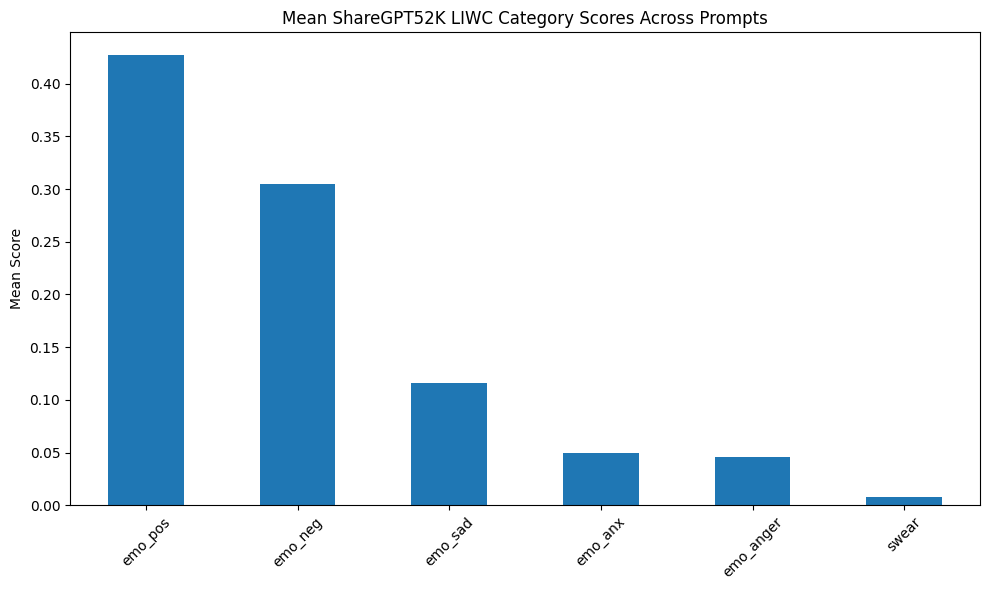

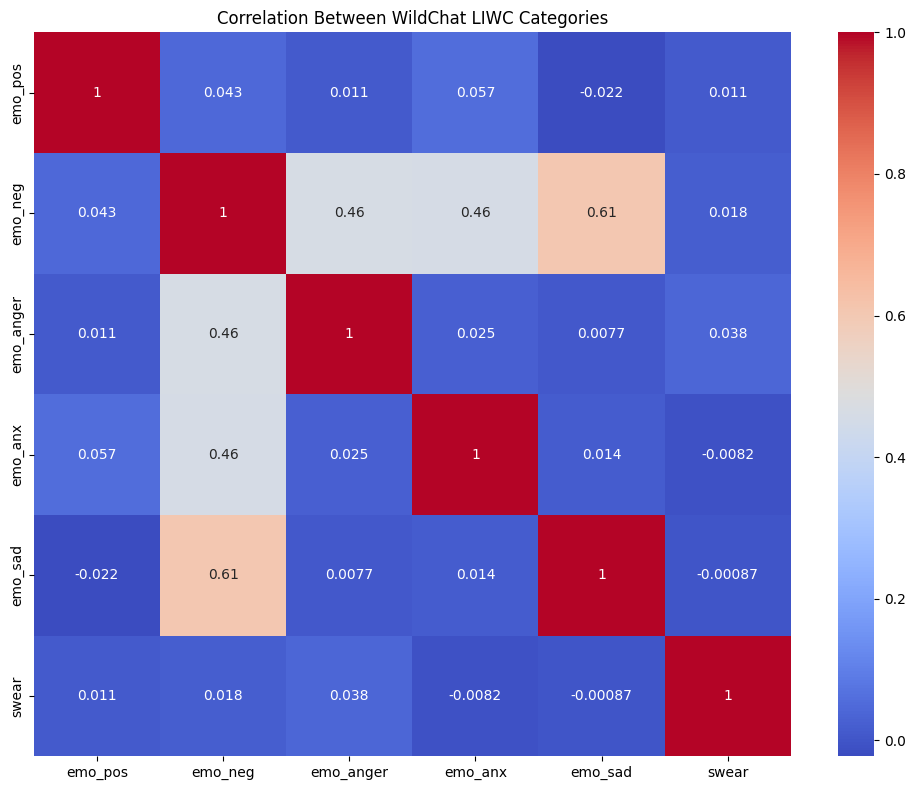

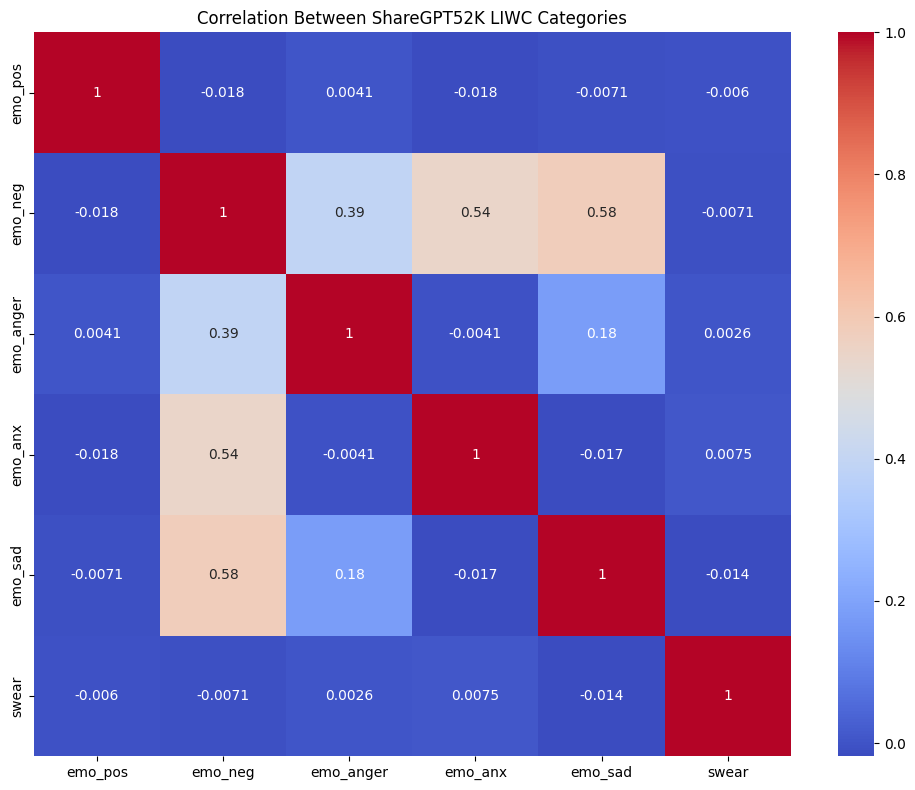

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select LIWC categories
liwc_categories = ['emo_pos', 'emo_neg', 'emo_anger', 'emo_anx', 'emo_sad', 'swear']

# Subset and reshape to long format
wildchat_long = wildchat_liwc[liwc_categories].melt(var_name='Category', value_name='Score')
sharegpt_long = sharegpt_liwc[liwc_categories].melt(var_name='Category', value_name='Score')

# Plots
plt.figure(figsize=(12, 6))
sns.boxplot(x='Category', y='Score', data=wildchat_long)
plt.title("WildChat Distribution of LIWC Category Scores")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='Category', y='Score', data=sharegpt_long)
plt.title("ShareGPT52K Distribution of LIWC Category Scores")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

wildchat_liwc[liwc_categories].mean().sort_values(ascending=False).plot(
    kind='bar',
    figsize=(10, 6),
    title="Mean WildChat LIWC Category Scores Across Prompts"
)
plt.ylabel("Mean Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

sharegpt_liwc[liwc_categories].mean().sort_values(ascending=False).plot(
    kind='bar',
    figsize=(10, 6),
    title="Mean ShareGPT52K LIWC Category Scores Across Prompts"
)
plt.ylabel("Mean Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(wildchat_liwc[liwc_categories].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Between WildChat LIWC Categories")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(sharegpt_liwc[liwc_categories].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Between ShareGPT52K LIWC Categories")
plt.tight_layout()
plt.show()

In [37]:
top_emotional = wildchat_liwc.sort_values('emo_neg', ascending=False).head(10)
print(top_emotional[['prompt', 'Affect', 'emo_pos', 'emo_neg']])

top_emotional = sharegpt_liwc.sort_values('emo_neg', ascending=False).head(10)
print(top_emotional[['prompt', 'Affect', 'emo_pos', 'emo_neg']])

                                                prompt  Affect  emo_pos  \
195  would she say top exercise and alleviate stres...    9.68     0.00   
97   still getting the same errors. here is the .ve...    9.02     0.00   
229  if you would have told that to them you would ...    6.25     0.00   
470  the fairies seem very skittish and wary of jac...    8.45     0.00   
308  i am considering a career move to a new profes...   14.00     4.00   
66   2 / 2write an insane 100-word trump tweet comp...    3.85     0.00   
61   rewrite the to be less offensive and more poli...    3.70     0.00   
389  write a 1st person pov introspective short sto...   11.11     0.00   
222  1. oily\n2. acne (and maybe hyperpigmentation)...    5.95     1.19   
434  def add_black_clip(clips):\n    from moviepy.v...    3.51     0.00   

     emo_neg  
195     9.68  
97      7.52  
229     6.25  
470     5.63  
308     4.00  
66      3.85  
61      3.70  
389     3.70  
222     3.57  
434     3.51  


### In step 4 we run selected prompts through langchain 

In [45]:
!pip install --quiet langchain langchain-groq  langchain-core

GROQ_API_KEY=""

from langchain_core.prompts import ChatPromptTemplate
from langchain_groq import ChatGroq

chat = ChatGroq(temperature=2, groq_api_key=GROQ_API_KEY, model_name="llama-3.3-70b-versatile")

In [77]:
system = "You are an assistant."
human = "{text}"
prompt = ChatPromptTemplate.from_messages([("system", system), ("human", human)])

text = "Why are some people bad at driving?"

chain = prompt | chat
response = chain.invoke({
    "text": f"<I want to feed prompts into an LM. Provide me 5 different versions of the following prompt with varying anger levels, 1 being not angry and 5 being extremely angry: '{text}'>"
})
print(response.content)

Here are 5 versions of the prompt with varying levels of anger:

1. **Not angry**: "I've noticed that some people seem to struggle with driving. What are some common challenges that might contribute to this?"
2. **Mildly annoyed**: "It's frustrating to see some people driving recklessly on the road. What are some possible reasons why they might not be taking the necessary precautions to drive safely?"
3. **Somewhat irritated**: "Why do some people insist on driving so poorly? It's not just a matter of personal safety, but also a risk to others on the road. What's behind this careless behavior?"
4. **Angry**: "It's absolutely infuriating to see some people driving like they own the place, putting everyone else at risk. What is wrong with these individuals that they can't even be bothered to follow basic traffic rules?"
5. **Extremely angry**: "Are you kidding me?! Some people are downright catastrophic behind the wheel, and it's a miracle nobody gets hurt. What is wrong with our society